# GECCO2018 Water Quality — Notebook 03: Anomaly Visualizations

Este notebook foca em **visualizações de anomalias** detectadas no dataset GECCO2018.

Objetivos:
- Analisar características temporais das anomalias.
- Criar visualizações em janela (zoom) para explorar anomalias em detalhe.
- Fornecer função simples e bem comentada para análise de janelas temporais.
- Comparar comportamento de múltiplos sensores durante eventos anômalos.

In [1]:
# Ensure project root on sys.path for `import src.*`
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print("sys.path bootstrapped with:", PROJECT_ROOT)

sys.path bootstrapped with: /home/nelso/Documents/IA - Detecção Falhas


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.paths import ensure_directories_exist, FIGURES_DIR
from src.data.loaders import load_gecco2018_csv

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

In [3]:
# Ensure data/ and reports/figures directories exist
ensure_directories_exist()
print("FIGURES_DIR:", FIGURES_DIR)

FIGURES_DIR: /home/nelso/Documents/IA - Detecção Falhas/reports/figures


In [4]:
# Load dataset
try:
    df = load_gecco2018_csv()
except FileNotFoundError as e:
    print(e)
    raise

print(df.shape)
df.head()

(139566, 12)


,Unnamed: 0,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,1,2016-08-03 11:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2,2016-08-03 11:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,3,2016-08-03 11:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,4,2016-08-03 11:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,5,2016-08-03 11:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


In [5]:
# Basic cleaning: drop unnamed, parse time, coerce types, drop nulls
# Drop unnamed index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Parse Time
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

# Coerce numeric columns
numeric_cols = ["Tp", "Cl", "pH", "Redox", "Leit", "Trueb", "Cl_2", "Fm", "Fm_2"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Ensure EVENT is boolean
if df["EVENT"].dtype != bool:
    df["EVENT"] = df["EVENT"].astype(str).str.lower().isin(["true", "1", "t", "yes"])

# Drop rows with nulls in Time or numeric sensors
df_clean = df.dropna(subset=["Time"] + numeric_cols)

# Sort by time and set index
df_clean = df_clean.sort_values("Time").reset_index(drop=True)
df_ts = df_clean.set_index("Time").sort_index()

print("After cleaning:", df_ts.shape)
print("EVENT true count:", int(df_ts["EVENT"].sum()))
print("Time range:", df_ts.index.min(), "->", df_ts.index.max())

After cleaning: (138521, 10)
EVENT true count: 1726
Time range: 2016-08-03 11:49:00 -> 2016-11-08 08:54:00


## Anomaly-Focused Visualizations

As per the Novel Dynamic Ensemble paper (Ribeiro et al., 2020), we now add **zoomed visualizations** that focus on anomaly regions. This dual perspective (overview + close-up) helps understand anomaly patterns in detail.


In [6]:
def get_anomaly_windows(df_ts, event_col='EVENT', margin_minutes=60):
    """
    Extract time windows around anomalies with margin.
    Returns list of tuples: (start_time, end_time, anomaly_start, anomaly_end)
    """
    
    # Find contiguous anomaly regions
    events = df_ts[event_col].copy()
    # Identify transitions
    event_starts = events & ~events.shift(1, fill_value=False)
    event_ends = events & ~events.shift(-1, fill_value=False)
    
    start_times = df_ts.index[event_starts].tolist()
    end_times = df_ts.index[event_ends].tolist()
    
    if len(start_times) == 0:
        return []
    
    windows = []
    margin = pd.Timedelta(minutes=margin_minutes)
    
    for anom_start, anom_end in zip(start_times, end_times):
        # Add margin around anomaly
        win_start = max(df_ts.index.min(), anom_start - margin)
        win_end = min(df_ts.index.max(), anom_end + margin)
        windows.append((win_start, win_end, anom_start, anom_end))
    
    return windows

anomaly_windows = get_anomaly_windows(df_ts, margin_minutes=120)
print(f"Found {len(anomaly_windows)} anomaly regions")
if len(anomaly_windows) > 0:
    print(f"First anomaly window: {anomaly_windows[0][0]} to {anomaly_windows[0][1]}")


Found 51 anomaly regions
First anomaly window: 2016-08-14 16:54:00 to 2016-08-14 21:11:00


### Anomaly Statistics

Let's analyze the temporal characteristics of anomalies in the dataset.


ANOMALY TEMPORAL CHARACTERISTICS
Total anomaly regions: 51
Mean duration: 32.8 minutes
Median duration: 21.0 minutes
Min duration: 9.0 minutes
Max duration: 252.0 minutes
Std duration: 44.5 minutes


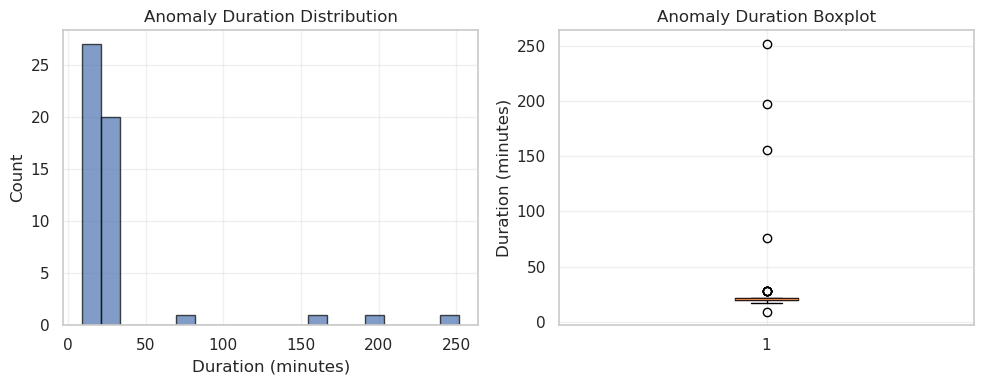

In [7]:
# Anomaly duration analysis
if len(anomaly_windows) > 0:
    durations = [(end - start).total_seconds() / 60 for _, _, start, end in anomaly_windows]
    
    print("=" * 60)
    print("ANOMALY TEMPORAL CHARACTERISTICS")
    print("=" * 60)
    print(f"Total anomaly regions: {len(anomaly_windows)}")
    print(f"Mean duration: {pd.Series(durations).mean():.1f} minutes")
    print(f"Median duration: {pd.Series(durations).median():.1f} minutes")
    print(f"Min duration: {pd.Series(durations).min():.1f} minutes")
    print(f"Max duration: {pd.Series(durations).max():.1f} minutes")
    print(f"Std duration: {pd.Series(durations).std():.1f} minutes")
    print("=" * 60)
    
    # Duration distribution
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(durations, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Count')
    plt.title('Anomaly Duration Distribution')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(durations, vert=True)
    plt.ylabel('Duration (minutes)')
    plt.title('Anomaly Duration Boxplot')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No anomalies found in dataset.")


### Visualizações em Janela (Zoom)

Criamos uma função simples para visualizar janelas de tempo específicas, facilitando a análise de anomalias em detalhe.


In [11]:
def plot_simple_zoom(df_ts, start_time, end_time, sensors=['Tp'], 
                     figsize=(14, 4), save_path=None):
    """
    Função SIMPLES para visualizar uma janela de tempo específica.
    
    Parâmetros:
    -----------
    df_ts : DataFrame
        DataFrame com índice temporal e coluna 'EVENT' (boolean)
    start_time : str ou datetime
        Início da janela (ex: '2016-08-14 17:00:00')
    end_time : str ou datetime
        Fim da janela (ex: '2016-08-14 20:00:00')
    sensors : list
        Lista de sensores para plotar (ex: ['Tp', 'pH', 'Cl'])
    figsize : tuple
        Tamanho da figura (largura, altura)
    save_path : str ou None
        Se fornecido, salva a figura neste caminho
    """
    
    # ===== 1. FILTRAR OS DADOS PARA A JANELA DE TEMPO =====
    # Converter strings para datetime se necessário
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)
    
    # Criar máscara booleana: True para linhas dentro da janela
    mask = (df_ts.index >= start_time) & (df_ts.index <= end_time)
    
    # Aplicar máscara para extrair apenas os dados da janela
    df_window = df_ts.loc[mask]
    
    # Verificar se há dados na janela
    if len(df_window) == 0:
        print(f"⚠️ Nenhum dado encontrado entre {start_time} e {end_time}")
        return
    
    # ===== 2. CRIAR A FIGURA E SUBPLOTS =====
    # Número de sensores = número de subplots (um por linha)
    n_sensors = len(sensors)
    
    # Criar figura com subplots empilhados verticalmente
    fig, axes = plt.subplots(n_sensors, 1, figsize=figsize, sharex=True)
    
    # Se só houver 1 sensor, axes não é uma lista, então transformamos em lista
    if n_sensors == 1:
        axes = [axes]
    
    # ===== 3. PLOTAR CADA SENSOR =====
    for i, sensor in enumerate(sensors):
        ax = axes[i]  # Pegar o subplot atual
        
        # Plotar linha do sensor (azul)
        ax.plot(df_window.index, df_window[sensor], 
                color='steelblue', linewidth=1.5, label='Leitura')
        
        # ===== 4. DESTACAR ANOMALIAS =====
        # Criar máscara para pontos anômalos (onde EVENT é True)
        anomaly_mask = df_window['EVENT']
        
        # Se houver anomalias na janela, destacá-las
        if anomaly_mask.any():
            # Plotar pontos vermelhos sobre as anomalias
            ax.scatter(df_window.index[anomaly_mask], 
                      df_window.loc[anomaly_mask, sensor],
                      color='crimson', s=30, marker='o', 
                      alpha=0.8, label='Anomalia', zorder=5)
            
            # Sombrear regiões anômalas com fundo vermelho transparente
            # Pegamos os limites do eixo Y para sombrear toda a altura
            ymin, ymax = ax.get_ylim()
            
            # Para cada ponto anômalo, criar uma faixa vertical
            anomaly_times = df_window.index[anomaly_mask]
            for anom_time in anomaly_times:
                # axvspan cria uma faixa vertical transparente
                ax.axvspan(anom_time, anom_time + pd.Timedelta(minutes=1), 
                          color='crimson', alpha=0.15, zorder=1)
        
        # ===== 5. CONFIGURAR LABELS E ESTILO =====
        # Título do subplot com nome do sensor
        ax.set_ylabel(sensor, fontsize=12, fontweight='bold')
        
        # Grid para facilitar leitura
        ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Legenda
        ax.legend(loc='upper right', fontsize=9)
    
    # ===== 6. TÍTULO GERAL E LABEL DO EIXO X =====
    # Título no topo da figura
    axes[0].set_title(f'Janela: {start_time.strftime("%Y-%m-%d %H:%M")} até '
                     f'{end_time.strftime("%Y-%m-%d %H:%M")}', 
                     fontsize=13, fontweight='bold', pad=10)
    
    # Label do eixo X apenas no último subplot
    axes[-1].set_xlabel('Tempo', fontsize=11)
    
    # Rotacionar labels do eixo X para não sobrepor
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=30, ha='right')
    
    # ===== 7. AJUSTAR LAYOUT E SALVAR/MOSTRAR =====
    plt.tight_layout()
    
    # Salvar figura se caminho foi fornecido
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✅ Figura salva: {save_path}")
    
    # Mostrar figura
    plt.show()

print("✅ Função plot_simple_zoom() criada com sucesso!")


✅ Função plot_simple_zoom() criada com sucesso!


In [ ]:
plot_simple_zoom()